In [27]:
'''
  File: SensorDriftAnalysis.ipynb
  Description: Observing before and after cases of sensor drift.
  Author: Johnathan Evans
  Created: 05/30/2023
  Updated: ...
'''
#imports
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as st
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import f
import statsmodels.api as sm
import matplotlib.pyplot as plt
import csv

"Borrowed"
def selectPeriods(df, delta_t):
    pointer = 5
    endSpots = []
    setPoints = []
    while pointer < len(df) - 3:
        if (int(df.loc[pointer, 'Target ppm']) - int(df.loc[pointer - 1, 'Target ppm'])) != 0:
            endSpots.append(pointer - 1)
            pointer += 1
        else:
            pointer += 1
    endSpots.append(len(df) - 3)
    for item in endSpots:
        setPoints.append([item - delta_t, item])
    return setPoints


In [7]:
# Funk Equation - Borrowed from colleague

# Load data from CSV file
file2 = pd.read_csv("../Output/BenSummaryJustMatrix.csv")

# Extract the columns from the data
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']

# Separate the independent and dependent variables
X = file2.drop('Target PPM', axis='columns')
y = file2.loc[:, 'Target PPM']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#+ g * np.exp(-1 * T*h + i)
def funct3(X, a, b, c, d, e,f,j):
    R, H, T = X
    return a * np.exp(-1 * R*b + c)+ d * np.exp(-1 * H*e + f) + j
p0 = 1,1,.5,1,1,1,1

# Perform curve fitting using the funct function, xDataResistance, and yDataTargetPPM data
# Set the maximum number of function evaluations to 1000000
popt, pcov = sc.optimize.curve_fit(funct3, (xDataResistance,xDataRH, xDataTemp), yDataTargetPPM,p0, maxfev=1000000)

# Print the optimized parameters
#print(popt)


y_pred = funct3((xDataResistance,xDataRH, xDataTemp), *popt)
print('R-squared: ', r2_score(y, y_pred))

# Calculate residuals
residuals = y - y_pred

# Reshape your input data to fit the het_breuschpagan function requirements
exog = np.vstack((xDataResistance, xDataRH, xDataTemp)).T

# Extract the Resistance column from the X_test dataframe
R_test = X_test.loc[:, 'Resistance']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']

# Generate the predictions using the optimized parameters and the input data
y_pred = funct3((R_test,H_test, T_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print('Stdev: ',testVal)

R-squared:  0.9425809732540373
Stdev:  77.3775622907143


/tmp/ipykernel_15613/1091745471.py:24: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-1 * R*b + c)+ d * np.exp(-1 * H*e + f) + j
/tmp/ipykernel_15613/1091745471.py:24: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-1 * R*b + c)+ d * np.exp(-1 * H*e + f) + j


file1
file2


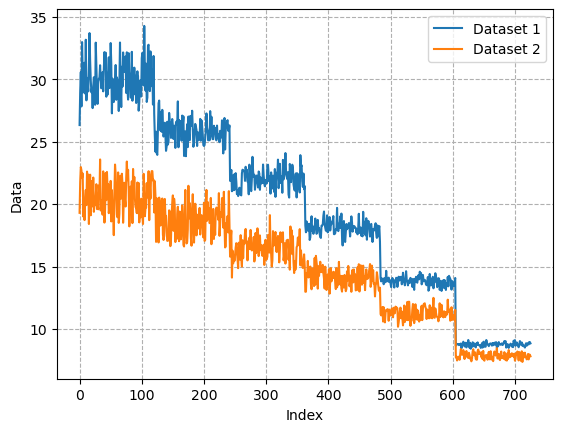

In [46]:
# Define the function to extract data
def extract_data(filename):
    pdadata = pd.read_csv(filename)
    indexes = selectPeriods(pdadata, 120)
    data=pd.DataFrame()
    for i in range(0, len(indexes)):
        data2 = pdadata.loc[indexes[i][0]:indexes[i][1],:]
        data=pd.concat([data,data2], ignore_index=True)
    Vout = data.iloc[:, 4].astype(float)
    Vref = data.iloc[:, 20].astype(float)
    extracted_data = (Vref * (5 - Vout)) / (Vout * (5 - Vref))
    return extracted_data

# Read and extract data from the first CSV file
file1 = 'JohnathanDataStorage/0C%5Best.csv'
print("file1")
data1 = extract_data(file1)

# Read and extract data from the second CSV file
file2 = 'JohnathanDataStorage/0C%5Re.csv'
print("file2")
data2 = extract_data(file2)
data2=data2*1.0
# Plot the datasets against each other
plt.plot(data1, label='Dataset 1')
plt.plot(data2, label='Dataset 2')

# Include horizontal gridlines
plt.grid(True, linestyle='--')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Data')
plt.legend()

# Display the plot
plt.show()